<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_09_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## Resources:

* Book version webpage: https://www.learnpytorch.io/09_pytorch_model_deployment/
* Notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb

## 0. Get Setup

## 1. Getting data

We left off in [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size) comparing our own Vision Transformer (ViT) feature extractor model to the EfficientNetB2 (EffNetB2) feature extractor model we created in [07. PyTorch Experiment Tracking](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#9-load-in-the-best-model-and-make-predictions-with-it).

And we found that there was a slight difference in the comparison.

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%.

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the [20% pizza, steak and sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples (one model trained on a dataset to another model trained on the same dataset).

> **Note:** The dataset we're downloading is a sample of the entire [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html#food101) (101 food classes with 1,000 images each). More specifically, 20% refers to 20% of images from the pizza, steak and sushi classes selected at random. You can see how this dataset was created in [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) and more details in [04. PyTorch Custom Datasets section 1](https://www.learnpytorch.io/04_pytorch_custom_datasets/#1-get-data).

We can download the data using the `download_data()` function we created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data) from [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 3426 (delta 52), reused 100 (delta 44), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.49 MiB | 26.65 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:

1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place

  To try to achieve these goals, we're going to build two model experiments:

  1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
  2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

  

## 3. Creating an EffNetB2 feature extractor

Feature extractor - a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - 

In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds for reprocducibility
set_seeds()

# Set it to our output class number
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [9]:
def create_effnet_b2_model(out_features:int=3,
                           seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get EffNetB2 transforms
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  # Set it to our output class number; in_features and dropout param
  # are the same in the base EfficientNet_B2 model.
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=out_features,
              bias=True)
  )

  return effnetb2, effnetb2_transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnet_b2_model(out_features=3,
                                                       seed=42)

In [11]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 288, 288),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.2 Creating DataLoaders for EffNetB2

In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names, device

(15, 5, ['pizza', 'steak', 'sushi'], 'cuda')

### 3.3 Traning EffNetB2 feature extractor

In [15]:
from going_modular.going_modular import engine

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(params=effnetb2.parameters(),
                       lr=1e-3)

# Train
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=opt,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 Loss Curves

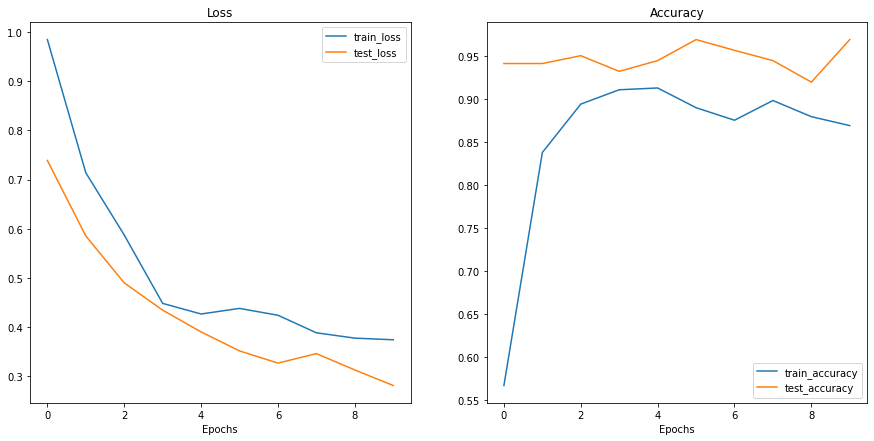

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inpsecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website there may be limited compute resources.

So if your model file is too large, we may not be able to fit it on the target device.

In [18]:
from pathlib import Path
model_path = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')
effnetb2_size_in_mb = model_path.stat().st_size / (1024 ** 2)
print(f'effnetb2 model size: {round(effnetb2_size_in_mb, 2)}MB')

effnetb2 model size: 29.86MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [19]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

effnetb2_total_params

7705221

In [20]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    'test_loss': effnetb2_results['test_loss'][-1],
    'test_acc': effnetb2_results['test_acc'][-1],
    'number_of_parameters': effnetb2_total_params,
    'model_size (MB)': effnetb2_size_in_mb
}

effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor.

In [21]:
# Checkout the heads layer of the vit model
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_a6 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  torch.manual_seed(seed)

  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
from torchinfo import summary

# # Print ViT model summary (uncomment for full output) 
# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT feature Extractor

In [25]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [26]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names, device

(15, 5, ['pizza', 'steak', 'sushi'], 'cuda')

### 4.1 Training ViT Feature Extractor

In [27]:
from going_modular.going_modular import engine

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(params=vit.parameters(),
                       lr=1e-3)

# Train
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            epochs=10,
                            optimizer=opt,
                            loss_fn=loss_fn,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT Feature Extractor

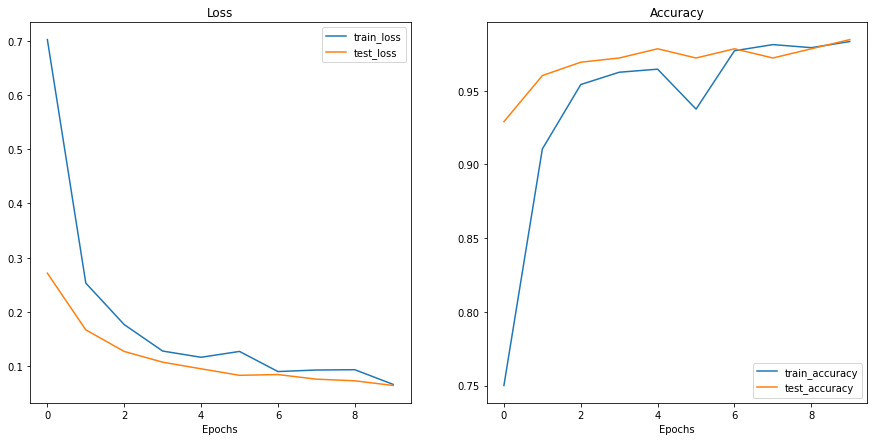

In [28]:
plot_loss_curves(vit_results)

### 4.4 Save ViT model and inspect the size

In [29]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir='models',
                 model_name='09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [30]:
from pathlib import Path
vit_model_path = Path('models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')
vit_size_in_mb = vit_model_path.stat().st_size / (1024 ** 2)
print(f'ViT model size: {round(vit_size_in_mb, 2)}MB')

ViT model size: 327.37MB


### 4.6 Collecting ViT Feature Extractor Stats

In [31]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

vit_total_params

85800963

In [32]:
vit_stats = {
    'test_loss': vit_results['test_loss'][-1], # -1 for the last epoch
    'test_acc': vit_results['test_acc'][-1],
    'number_of_parameters': vit_total_params,
    'model_size (MB)': vit_size_in_mb
}

vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths

In [33]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/864661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg')]

### 5.1 Creating a function to make predictions across test dataset

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms, a list of target class names, and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will be inside the loop)
4. Create an empty dictionary for each sample (prediction statistics will go in here)
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turnn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [34]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available else 'cpu') -> List[Dict]:
  # 2. Create an empty list
  pred_list = []
  # 3. Loop through the target input paths
  for path in tqdm(paths):
    # 4. Create an empty dictionary for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth path from file path
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image
    img = Image.open(path)

    # 8. Transform the image
    # 8.1 note that we add a batch dimension
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Put the model on the target device and into eval mode
    model = model.to(device)
    model.eval()

    # 10. Turnn on torch.inference_mode() and pass the target transformed
    # image to the model and perform forward pass + calculate pred prob + 
    # pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into pred prob
      pred_label = torch.argmax(pred_prob, dim=1) # prob into label index
      pred_class = class_names[pred_label.cpu()] # move pred to cpu (Python variables live on CPU)

      # 11. Add the pred to the output dict
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class

      # 12. End the timer and add the time to the dict
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class
    pred_dict['correct'] = class_name == pred_class

    # 14. Append the dictionary to the list of predictions
    pred_list.append(pred_dict)

  # 15 . Return the lsit of prediction dictionaries
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Two things to note:

1. Device - we're going to hardcode predictions to happen on CPU (because you won't always be sure you'll have a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [35]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6322,
  'pred_class': 'steak',
  'time_for_pred': 0.3515,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8868,
  'pred_class': 'steak',
  'time_for_pred': 0.1449,
  'correct': True}]

In [37]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6322,steak,0.3515,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8868,steak,0.1449,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.4127,steak,0.1427,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5829,sushi,0.1394,False
4,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.6724,steak,0.1458,True


In [38]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [39]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f'EffNetB average time per prediction: {effnetb2_average_time_per_pred}')

EffNetB average time per prediction: 0.1076


In [40]:
# Add average time per prediction to effnetb2 stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.1076}

> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using. So generally the faster the compute the faster predictions will happen.

(Running the above on GPU will be 10x faster).

### 5.3 Making and timing predictions with ViT

In [41]:
# Make predictions across test dataset with ViT
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [42]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5999,steak,0.6425,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9719,steak,0.4138,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9630,steak,0.4036,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4719,steak,0.3845,True
4,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9986,steak,0.4032,True


In [43]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [44]:
# Find the average time per prediction for vit
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f'ViT average time per prediction: {vit_average_time_per_pred}')

ViT average time per prediction: 0.4244


In [45]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.4244}

## 6. Comparing model results, prediction times and size

In [46]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29.863233,0.1076,EffNetB2
1,0.064182,98.47,85800963,327.370387,0.4244,ViT


Which model is better?

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2
  * *sometimes models with higher parameters can still run fast
* `model_size (MB)` - EffNetB2 (for our use case of mobile deployment smaller is better)
* `time_per_pred_cpu` - (lower is better, highly dependent on hardware) - EffNetB2

Both models fail to achieve our goal of 30+FPS, however we could always just try and use EffNetB2 and see how it goes.

In [47]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2'],
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,10.962323,3.944238


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

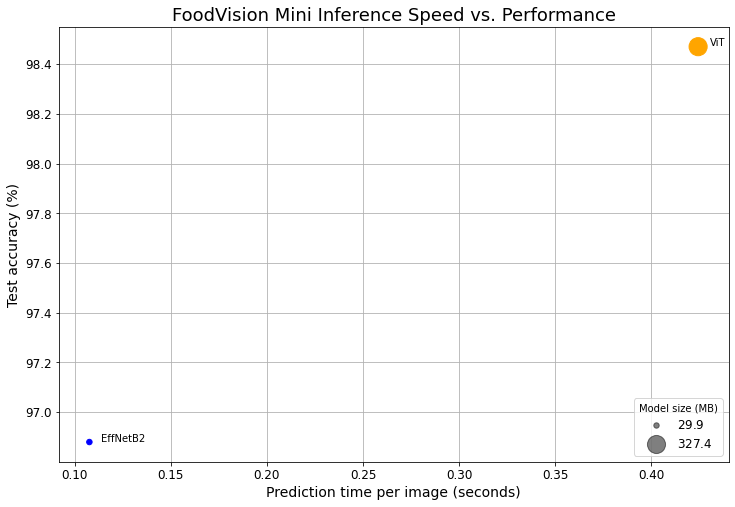

In [48]:
import matplotlib.pyplot as plt
# 1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')
# 2. Add titles and labels to make our plot look nice.
ax.set_title('FoodVision Mini Inference Speed vs. Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)
# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(s=row['model'],
              xy=(row['time_per_pred_cpu']+0.006, row['test_acc']+0.003))
# 4. Create a legend based on the model sizes (`model_size (MB)`)
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc='lower right', 
                              title='Model size (MB)',
                              fontsize=12)
# Save the figure
plt.savefig('09-foodvision-mini-inference-speed-vs-performance.png')

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfuls our criteria the best. (But look at onnx and OpenVINO for inference performance improvements).

What is Gradio? https://gradio.app/

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!



In [49]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f'Gradio version: {gr.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs and outputs

In [50]:
# Put our model on the CPU
effnetb2 = effnetb2.to('cpu') # so we use the free tier on HuggingFace

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs food class
```

In [51]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_image = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(transformed_image), dim=1) # turn logits into pred prob

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = dict(zip(class_names, [i.item() for i in pred_probs[0]]))
  # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [52]:
test_image_path = test_data_paths[0]
test_image = Image.open(test_image_path)
probs, time = predict(test_image)
print(f'For {test_image_path}: {probs}, {time}')

For data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg: {'pizza': 0.24962171912193298, 'steak': 0.6321924924850464, 'sushi': 0.11818575114011765}, 0.1083


### 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter.

In [53]:
import random
# Create a list of example inputs to our Gradio demo
example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/367422.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg']

## 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time
```

In [54]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/efficientnetv2.html) computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. [PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)."

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# demo.launch(debug=False,
#             share=True)

## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Gradio public demos expire in 72 hours, but we can put them up on Hugging Face Spaces.

### 8.1 What is Hugging Face Spaces?

Hugging Face spaces is an easy way to host an ML app. Or, you know, "github for machine learning"

### 8.2 Deployed Gradio app structure

We might have to use `git-lfs` for storing the model files.

We'll want all of our app files in a single directory.

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this structure?

Because it's one of the simplest we could start with.

You can see this in action:
* Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
* Example file structure: https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main


In [55]:
### 8.3 Creating a `demos` folder to store our FoodVision app files

In [56]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini/')

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [57]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# copy the first image in each class's directory to the examples dir:
for classname in class_names:
  path = test_dir / classname
  imagefile = next(Path(path).glob("*.jpg"))
  print(f'[INFO] Copying {imagefile} to {foodvision_mini_examples_path}')
  shutil.copy2(src=imagefile, dst=foodvision_mini_examples_path)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg to demos/foodvision_mini/examples
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg to demos/foodvision_mini/examples
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/1404154.jpg to demos/foodvision_mini/examples


Let's now verify that we can get gradio to work:


In [58]:
example_list = list(foodvision_mini_examples_path.glob('*.jpg'))
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

In [59]:
# demo.launch()

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [60]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = 'models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'

# Create a destination path, which is silly!
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

# Move the model file if it's not already there:
try:
  print(f'[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}')
  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print(f'[INFO] Model move complete.')
except Exception as e:
  print(f'[INFO] No model found at {effnetb2_foodvision_mini_model_path}. Has it been moved?')
  print(f'[INFO] Model {"already found" if effnetb2_foodvision_mini_model_destination.exists() else "not found"} at {effnetb2_foodvision_mini_model_destination}')

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into an instantiated PyTorch model.

In [61]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnet_b2_model(num_classes:int=3,
                           seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get EffNetB2 transforms
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  # Set it to our output class number; in_features and dropout param
  # are the same in the base EfficientNet_B2 model.
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)
  )

  return effnetb2, effnetb2_transforms

Writing demos/foodvision_mini/model.py


In [62]:
from demos.foodvision_mini import model
# Just test that we saved the model loading file correctly:
effnetb2_model, effnetb2_transforms_import = model.create_effnet_b2_model()
# effnetb2_model

### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` will have four major pats:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()` above)
4. Gradio app - our Gradio interface + launch

In [63]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
from pathlib import Path

from model import create_effnet_b2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnet_b2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(torch.load(f='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth',
                         map_location=torch.device('cpu'))) # load model on CPU

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_image = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(transformed_image), dim=1) # turn logits into pred prob

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = dict(zip(class_names, [i.item() for i in pred_probs[0]]))
  # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time


### 4. Gradio App ###

# Create example list
example_list = list(Path('examples/').glob('*.jpg'))

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/efficientnetv2.html) computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. [PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)."

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'), 
                    outputs=[gr.Label(num_top_classes=len(class_names),
                                      label="Predictions"),
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!
demo.launch(debug=False,
            share=False)


Writing demos/foodvision_mini/app.py


### 8.8 Creating a Python requirements file for FoodVision Mini (`requirements.txt`)

* `torch`
* `torchvision`
* `gradio`

In [64]:
torch.__version__

'1.13.1+cu116'

In [65]:
torchvision.__version__

'0.14.1+cu116'

In [66]:
gr.__version__

'3.17.1'

In [67]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.13.1
torchvision==0.14.1
# gradio==3.17.1 # in theory, hugging face uses the latest gradio

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini App to HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to HuggingFace.


In [68]:
!find demos/foodvision_mini

demos/foodvision_mini
demos/foodvision_mini/__pycache__
demos/foodvision_mini/__pycache__/model.cpython-38.pyc
demos/foodvision_mini/model.py
demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
demos/foodvision_mini/app.py
demos/foodvision_mini/requirements.txt
demos/foodvision_mini/examples
demos/foodvision_mini/examples/1335842.jpg
demos/foodvision_mini/examples/1404154.jpg
demos/foodvision_mini/examples/3486640.jpg


In [69]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*__pycache__*" "*.ipynb" "*.pyc" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/1335842.jpg (deflated 0%)
  adding: examples/1404154.jpg (deflated 0%)
  adding: examples/3486640.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 13%)


In [117]:
from google.colab import files

# Download
def download_zip_locally(path):
  try:
    files.download(path)
  except:
    print(f'Not running in Google Colab, please download {path} manually')

# download_zip_locally()

### 9.2 Running our Gradio demo app locally

If you download the `foodvision_mini.zip` file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
5. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
    * **Note:** This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade `pip` first: `pip install --upgrade pip`.
6. Run the app (`python3 app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.

> **Note:** If you run the app locally and you notice a `flagged/` directory appear, it contains samples that have been "flagged". 
>
> For example, if someone tries the demo and the model produces an incorrect result, the sample can be "flagged" and reviewed for later.
> 
> For more on flagging in Gradio, see the [flagging documentation](https://gradio.app/docs/#flagging).

### 9.3 Uploading our FoodVision Minio Gradio demo to Hugging Face Spaces


### 9.3 Uploading to Hugging Face

We've verfied our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face. 

> **Note:** The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the [Git and GitHub for Beginners tutorial](https://youtu.be/RGOj5yH7evk) on freeCodeCamp.

1. [Sign up](https://huggingface.co/join) for a Hugging Face account. 
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit). 
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Mini Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_mini` app files and commit them with: 
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked, you should see a live running example of our FoodVision Mini Gradio demo like the one here: https://huggingface.co/spaces/mrdbourke/foodvision_mini 

And we can even embed our FoodVision Mini Gradio demo into our notebook as an [iframe](https://gradio.app/sharing_your_app/#embedding-with-iframes) with [`IPython.display.IFrame`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.IFrame) and a link to our space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

In [71]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [72]:
#!cd gdrive/MyDrive; sudo git clone https://huggingface.co/spaces/gavindoughtie/foodvisionmini

In [73]:
# !cd gdrive/MyDrive/foodvisionmini; git lfs install
# !cp -r demos/foodvision_mini/* gdrive/MyDrive/foodvisionmini
# !cd gdrive/MyDrive/foodvisionmini; git config --global user.email "gavin@doughtie.com"
# !cd gdrive/MyDrive/foodvisionmini; git config --global user.name "gavindoughtie"
# !cd gdrive/MyDrive/foodvisionmini; git lfs track "*.pth"; git add .gitattributes
# !cd gdrive/MyDrive/foodvisionmini; git add *; git commit -am 'Added files'

After running the cell below, run `cd gdrive/MyDrive/foodvisionmini; git lfs install; git push`

In [74]:
# !pip install colab-xterm
# %load_ext colabxterm
# %xterm

In [75]:
from IPython.display import IFrame

url = 'https://gavindoughtie-foodvisionmini.hf.space'
# IFrame(src=url, width=900, height=750)

## 10. Creating FoodVision Big!!!

FoodVision Mini works well with 3 classes (pizza/steak/sushi).

So all of our experimenting is paying off, so let's step things up a notch and make FoodVision BIG using all of the Food101 classes.

### 10.1 Creating a model for FoodVision Big + transforms

In [76]:
import torch
import torchvision
from torch import nn

def create_effnet_b2_model(num_classes:int=3,
                           seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get EffNetB2 transforms
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  # Set it to our output class number; in_features and dropout param
  # are the same in the base EfficientNet_B2 model.
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)
  )

  return effnetb2, effnetb2_transforms

In [77]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnet_b2_model(num_classes=101)

In [78]:
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique.

For a list of SOTA computer vision recipes: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [79]:
# Create training data transforms
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [80]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

Get the Food101 dataset: https://pytorch.org/vision/0.12/generated/torchvision.datasets.Food101.html

In [81]:
# First, connect my google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
from torchvision import datasets

# Setup data directory

from pathlib import Path
import shutil

data_dir = Path('data')
food_101_dir = data_dir / 'food-101'
data_backup_dir = Path('/content/gdrive/MyDrive/pytorch_class/data')
food_101_backup_dir = data_backup_dir / 'food-101'

download_data = False
copy_to_backup_dir = False

# if not data_backup_dir.exists():
#   print(f'[INFO] Creating backup data dir {data_backup_dir}')
#   data_backup_dir.mkdir(parents=True, exist_ok=True)
#   copy_to_backup_dir = True

# # We have the data and we need to copy it
# if not food_101_dir.exists() and food_101_backup_dir.exists():
#   print(f'[INFO] copying backup snapshot of data to {food_101_dir}')
#   shutil.copy2(food_101_backup_dir, food_101_dir)
# else:
#   download_data = True

# # Get the training data (~750 x 101 classes)
# print(f'[INFO] {"downloading" if download_data else "loading"} training data')
train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform=food_101_train_transforms, # apply augmentation to training data
                              download=True)

# if copy_to_backup_dir:
#   print(f'[INFO] copying downloaded data to GDrive {food_101_backup_dir}')
#   shutil.copy2(food_101_dir, food_101_backup_dir)


# Get the testing data (~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split='test',
                             transform=effnetb2_transforms, # no augmentation on test data
                             download=True)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [83]:
# Get Food101 class names
food_101_class_names = train_data.classes

# View the first 10
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.04% accuracy on the test data set.

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [84]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f'[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}')

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [85]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [86]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food 101 datasets into `DataLoader`s

In [87]:
import torch
import os

NUM_WORKERS = 2 # a topic of research
BATCH_SIZE = 32

# Create Food101 20 training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20 testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

# print batch counts
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big model

FoodVision Big model and `DataLoader`s ready!

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with [`torchvision`'s state-of-the-art training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing).

What's [**label smoothing**](https://paperswithcode.com/method/label-smoothing)? 

Label smoothing is a regularization technique (regularization is another word to describe the process of [preventing overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting)) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting *too confident* on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model *without* label smoothing had the following outputs for 5 classes:

```
[0, 0, 0.99, 0.01, 0]
```

A model *with* label smoothing may have the following outputs:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

Finally, to keep things quick, we'll train our model for five epochs using the `engine.train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them) with the goal of beating the original Food101 paper's result of 56.4% accuracy on the test set.

Let's train our biggest model yet!

> **Note:** Running the cell below will take ~15-20 minutes to run on Google Colab. This is because it's training the biggest model with the largest amount of data we've used so far (15,150 training images, 5050 testing images). And it's a reason we decided to split 20% of the full Food101 dataset off before (so training didn't take over an hour). 

In [88]:
from going_modular.going_modular import engine

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # regularization technique, but cheap to run; accounts for errors in training data

# Optimizer
opt = torch.optim.Adam(params=effnetb2_food101.parameters(),
                       lr=1e-3)

# Train
set_seeds()
effnetb2_results = engine.train(model=effnetb2_food101,
                                train_dataloader=train_dataloader_food101_20_percent,
                                test_dataloader=test_dataloader_food101_20_percent,
                                epochs=5,
                                optimizer=opt,
                                loss_fn=loss_fn,
                                device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6417 | train_acc: 0.2804 | test_loss: 2.7815 | test_acc: 0.4915
Epoch: 2 | train_loss: 2.8621 | train_acc: 0.4410 | test_loss: 2.4731 | test_acc: 0.5332
Epoch: 3 | train_loss: 2.6545 | train_acc: 0.4861 | test_loss: 2.3638 | test_acc: 0.5566
Epoch: 4 | train_loss: 2.5437 | train_acc: 0.5140 | test_loss: 2.3022 | test_acc: 0.5735
Epoch: 5 | train_loss: 2.4955 | train_acc: 0.5252 | test_loss: 2.2800 | test_acc: 0.5802


### 10.6 Inspecting Loss Curves of FoodVision Big model

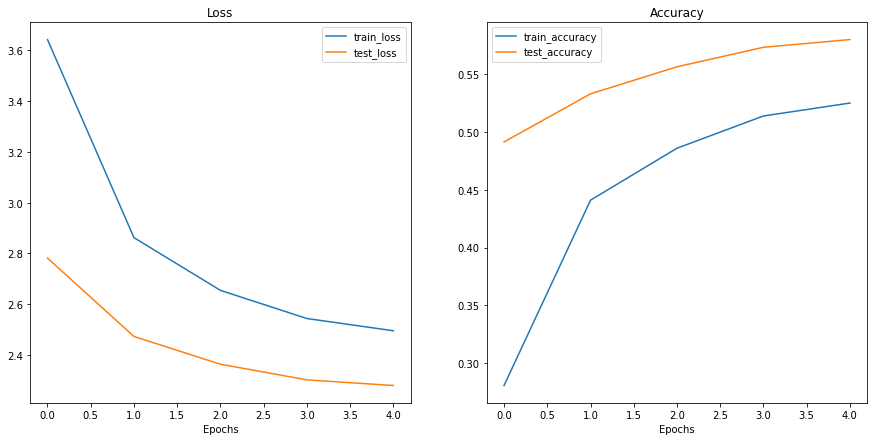

In [89]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 10.7 Save and load FoodVision Big model

In [90]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = '09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir='models',
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [91]:
# Create a Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnet_b2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load('models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'))

<All keys matched successfully>

In [92]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_food101_model_size = Path('models', effnetb2_food101_model_path).stat().st_size // (1024 ** 2)
print(f'Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_food101_model_size}MB')

Pretrained EffNetB2 feature extractor model size: 30MB


## 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how well your model works in the real world (the ultimate test set).

Let's create an outline for our FoodVision Big app:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```


In [95]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path('demos/foodvision_big')

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
examples_path = foodvision_big_demo_path / 'examples'
examples_path.mkdir(parents=True,
                    exist_ok=True)

## 11.1 Downloading an example image and moving it to the `examples` directory

In [96]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2023-02-05 14:53:10--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2023-02-05 14:53:11 (88.7 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.1.1 Making class_names.txt

In [102]:
class_names_file_path = foodvision_big_demo_path / 'class_names.txt'
with open(class_names_file_path, 'w') as f:
  for classname in food_101_class_names:
    f.write(classname + '\n')

In [105]:
# Open Food101 class names file and read each line into a list

with open(class_names_file_path, 'r') as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [106]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

def create_effnet_b2_model(num_classes:int=3,
                           seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2. Get EffNetB2 transforms
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use `weights="DEFAULT"`

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)

  # Set it to our output class number; in_features and dropout param
  # are the same in the base EfficientNet_B2 model.
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)
  )

  return effnetb2, effnetb2_transforms

Writing demos/foodvision_big/model.py


### 11.4 Creating a gradio app (`app.py`)

In [110]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
from pathlib import Path

from model import create_effnet_b2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open('class_names.txt', 'r') as f:
  class_names = [food.strip() for food in f.readlines()]

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnet_b2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(torch.load(f='09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth',
                         map_location=torch.device('cpu'))) # load model on CPU

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_image = effnetb2_transforms(img).unsqueeze(0).to('cpu')

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(transformed_image), dim=1) # turn logits into pred prob

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = dict(zip(class_names, [i.item() for i in pred_probs[0]]))
  # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time


### 4. Gradio App ###

# Create example list
example_list = list(Path('examples/').glob('*.jpg'))

# Create title, description and article
title = "FoodVision Big 🍕🥩🍣🥯🍔🌭"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/efficientnetv2.html) computer vision model to classify 101 clases of food."
article = "Created at 09. [PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)."

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'), 
                    outputs=[gr.Label(num_top_classes=5,
                                      label="Predictions"),
                             gr.Number(label="Prediction time (s)")], 
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!
demo.launch(debug=False,
            share=False)


Overwriting demos/foodvision_big/app.py


### 11.5 Create `requirements.txt` for FoodVision Big

In [111]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.13.1
torchvision==0.14.1
# gradio==3.17.1 # in theory, hugging face uses the latest gradio

Writing demos/foodvision_big/requirements.txt


### 11.6 Download the zip

In [114]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*__pycache__*" "*.ipynb" "*.pyc" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 13%)


In [118]:
# download_zip_locally('demos/foodvision_big.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check it out!

https://huggingface.co/spaces/gavindoughtie/foodvisionbig